# Setup

Please ensure you have imported a Gemini API key from AI Studio.
You can do this directly in the Secrets tab on the left.

After doing so, please run the setup cell below.

# Generated Code

--- Controle de Dias de Viagem de Piloto ---
Insira as informações das viagens.
Digite 'fim' a qualquer momento para encerrar a entrada de viagens.

--- Nova Viagem (1) ---
Título da viagem ou 'fim': viagem 1
Data de início da viagem (dd/mm/aaaa) ou 'fim': 01/01/2024
Data de término da viagem (dd/mm/aaaa) ou 'fim': 09/02/2024

Viagem adicionada.
Duração desta viagem: 40 dias
Total de dias em viagem fora da base nos últimos 365 dias (após esta viagem): 40 dias (Verde)

--- Nova Viagem (2) ---
Título da viagem ou 'fim': 10/03/2024
Data de início da viagem (dd/mm/aaaa) ou 'fim': 15/04/2024
Data de término da viagem (dd/mm/aaaa) ou 'fim': 23/05/2024

Viagem adicionada.
Duração desta viagem: 39 dias
Total de dias em viagem fora da base nos últimos 365 dias (após esta viagem): 79 dias (Verde)

--- Nova Viagem (3) ---
Título da viagem ou 'fim': viagem 3
Data de início da viagem (dd/mm/aaaa) ou 'fim': 20/06/2024
Data de término da viagem (dd/mm/aaaa) ou 'fim': 27/07/2024

Viagem adicionada.
Du

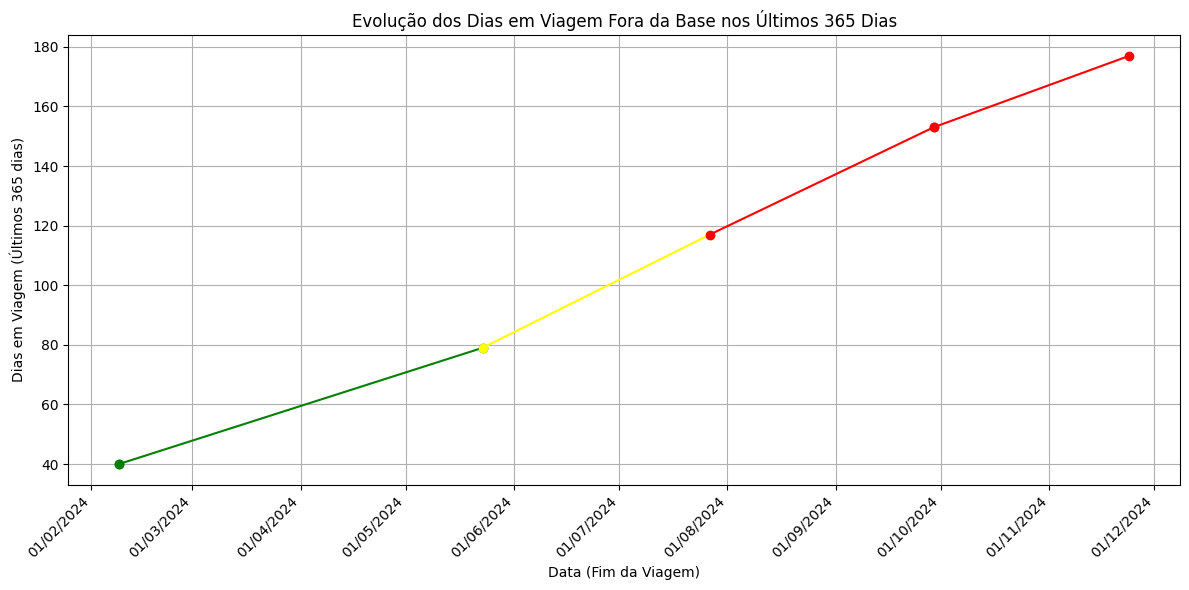


--- Fim do Programa ---


In [2]:
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Lista para armazenar as viagens (cada viagem será um dicionário)
# Exemplo: {'titulo': 'Viagem a Marte', 'inicio': date(2023, 1, 1), 'fim': date(2023, 1, 15)}
trips = []

def get_date_input(prompt):
    """Pede uma data ao usuário e a valida no formato dd/mm/aaaa."""
    while True:
        date_str = input(prompt)
        try:
            # Tenta converter a string para um objeto date usando o formato dd/mm/aaaa
            return datetime.datetime.strptime(date_str, '%d/%m/%Y').date()
        except ValueError:
            print("Formato de data inválido. Use o formato dd/mm/aaaa.")

def calculate_trip_duration(start_date, end_date):
    """Calcula a duração de uma viagem em dias (inclusive o dia de início e o dia de chegada)."""
    # A duração inclui o dia de início e o dia de fim
    return (end_date - start_date).days + 1

def calculate_interval(end_date_prev_trip, start_date_new_trip):
    """Calcula o intervalo entre o fim da viagem anterior e o início da nova viagem."""
    # O intervalo é do dia seguinte ao fim da viagem anterior até o dia anterior ao início da nova viagem
    # Se a nova viagem começar no dia seguinte ao fim da anterior, o intervalo é 0.
    return (start_date_new_trip - end_date_prev_trip).days -1

def is_within_last_365_days(check_date, relative_to_date):
    """Verifica se uma data está dentro dos 365 dias anteriores a uma data de referência."""
    return relative_to_date - timedelta(days=365) <= check_date <= relative_to_date

def calculate_days_in_window(trips_list, end_date_window):
    """Calcula o total de dias de viagem dentro da janela de 365 dias antes de end_date_window."""
    total_days = 0
    window_start = end_date_window - timedelta(days=365)

    for trip in trips_list:
        trip_start = trip['inicio']
        trip_end = trip['fim']

        # Calcula a sobreposição da viagem com a janela de 365 dias
        overlap_start = max(trip_start, window_start)
        overlap_end = min(trip_end, end_date_window)

        # Se houver sobreposição válida (início antes ou igual ao fim)
        if overlap_start <= overlap_end:
            # Adiciona 1 para incluir o dia final na contagem de dias
            total_days += (overlap_end - overlap_start).days + 1

    return total_days

def check_constraints(new_trip_start, new_trip_end, existing_trips):
    """Verifica as restrições para uma nova viagem e imprime alertas se violadas."""
    all_constraints_met = True

    # 1. Duração máxima da viagem (40 dias)
    duration = calculate_trip_duration(new_trip_start, new_trip_end)
    if duration > 40:
        print(f"\nALERTA: Violação de Regra - Duração da viagem ({duration} dias) excede o máximo permitido de 40 dias.")
        all_constraints_met = False

    # 2. Intervalo entre viagens (mínimo 60% da viagem anterior)
    if existing_trips:
        last_trip = existing_trips[-1]
        interval = calculate_interval(last_trip['fim'], new_trip_start)
        min_interval = calculate_trip_duration(last_trip['inicio'], last_trip['fim']) * 0.6

        # Ajuste: se o intervalo for negativo (nova viagem começa antes do fim da anterior), é inválido.
        # Se o intervalo for zero ou positivo, verificamos a regra de 60%.
        if interval < 0:
             print("\nALERTA: Violação de Regra - A nova viagem começa antes do fim da viagem anterior.")
             all_constraints_met = False
        elif interval < min_interval:
            print(f"\nALERTA: Violação de Regra - O intervalo entre as viagens ({interval} dias) é menor que 60% da duração da viagem anterior ({min_interval:.2f} dias).")
            all_constraints_met = False

    # 3. Total de dias nos últimos 365 dias (máximo 180 dias)
    # Simula a adição da nova viagem para verificar a restrição
    simulated_trips = existing_trips + [{'inicio': new_trip_start, 'fim': new_trip_end}]
    total_days_simulated = calculate_days_in_window(simulated_trips, new_trip_end)

    if total_days_simulated > 180:
        print(f"\nALERTA: Violação de Regra - Adicionar esta viagem faria o total de dias nos últimos 365 dias ({total_days_simulated} dias) exceder o limite de 180 dias.")
        all_constraints_met = False

    # Retorna True se todas as restrições foram atendidas, False caso contrário.
    # No entanto, a viagem será adicionada independentemente deste retorno no loop principal.
    return all_constraints_met

def get_color(total_days):
    """Retorna a cor baseada no total de dias."""
    if total_days < 100:
        return 'green'
    elif 100 <= total_days < 140:
        return 'yellow'
    else:
        return 'red'

def plot_travel_days_over_time(trips_list):
    """Gera o gráfico de linha mostrando o total de dias nos últimos 365 dias ao longo do tempo (fim de cada viagem), com cores dinâmicas."""
    if not trips_list:
        print("\nNenhuma viagem registrada para gerar o gráfico.")
        return

    dates_for_plot = []
    days_in_window_over_time = []

    # Calcula o total de dias nos últimos 365 dias após cada viagem
    for i in range(len(trips_list)):
        current_trips_subset = trips_list[:i+1] # Subset de viagens até a viagem atual
        current_trip = trips_list[i]
        reference_date = current_trip['fim'] # Data de referência é o fim da viagem atual

        # Calcula o total de dias nos últimos 365 dias considerando as viagens até a atual
        total_days = calculate_days_in_window(current_trips_subset, reference_date)

        dates_for_plot.append(reference_date)
        days_in_window_over_time.append(total_days)

    # Cria o gráfico
    fig, ax = plt.subplots(figsize=(12, 6)) # Ajusta o tamanho da figura

    # Plota os segmentos da linha com cores dinâmicas
    for i in range(len(dates_for_plot) - 1):
        start_date_segment = dates_for_plot[i]
        end_date_segment = dates_for_plot[i+1]
        start_days_segment = days_in_window_over_time[i]
        end_days_segment = days_in_window_over_time[i+1]

        # Determina a cor do segmento com base no valor final do segmento
        segment_color = get_color(end_days_segment)

        # Plota o segmento da linha
        ax.plot([start_date_segment, end_date_segment], [start_days_segment, end_days_segment],
                linestyle='-', color=segment_color, marker='o') # Adiciona marcador em cada ponto

    # Plota o primeiro ponto separadamente para garantir que o marcador apareça se houver apenas um ponto
    if dates_for_plot:
         ax.plot(dates_for_plot[0], days_in_window_over_time[0], marker='o', color=get_color(days_in_window_over_time[0]))


    # Formata o eixo x para mostrar as datas
    ax.xaxis.set_major_locator(mdates.AutoDateLocator()) # Localiza automaticamente as datas
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y')) # Formato dia/mês/ano

    # Rotaciona os rótulos do eixo x para melhor legibilidade
    plt.xticks(rotation=45, ha='right')

    ax.set_xlabel("Data (Fim da Viagem)")
    ax.set_ylabel("Dias em Viagem (Últimos 365 dias)")
    ax.set_title("Evolução dos Dias em Viagem Fora da Base nos Últimos 365 Dias")
    ax.grid(True)
    plt.tight_layout() # Ajusta o layout para evitar sobreposição

    plt.show()


# --- Loop Principal do Programa ---
print("--- Controle de Dias de Viagem de Piloto ---")
print("Insira as informações das viagens.")
print("Digite 'fim' a qualquer momento para encerrar a entrada de viagens.")

while True:
    print(f"\n--- Nova Viagem ({len(trips) + 1}) ---")
    trip_title = input("Título da viagem ou 'fim': ")
    if trip_title.lower() == 'fim':
        break

    start_date_input = input("Data de início da viagem (dd/mm/aaaa) ou 'fim': ")
    if start_date_input.lower() == 'fim':
        break

    end_date_input = input("Data de término da viagem (dd/mm/aaaa) ou 'fim': ")
    if end_date_input.lower() == 'fim':
        break

    try:
        # Usa a função get_date_input para obter e validar a data
        new_trip_start = datetime.datetime.strptime(start_date_input, '%d/%m/%Y').date()
        new_trip_end = datetime.datetime.strptime(end_date_input, '%d/%m/%Y').date()

        if new_trip_start > new_trip_end:
            print("\nErro: A data de início não pode ser posterior à data de término.")
            continue

        # Verifica as restrições. Alertas serão impressos dentro da função se houver violação.
        check_constraints(new_trip_start, new_trip_end, trips)

        # Adiciona a viagem independentemente de ter violado regras
        new_trip = {'titulo': trip_title, 'inicio': new_trip_start, 'fim': new_trip_end}
        trips.append(new_trip)
        print("\nViagem adicionada.") # Confirma que a viagem foi adicionada

        # 1. Mostrar duração da viagem adicionada
        current_trip_duration = calculate_trip_duration(new_trip_start, new_trip_end)
        print(f"Duração desta viagem: {current_trip_duration} dias")

        # 2. Mostrar dias em viagem nos últimos 365 dias após adicionar a viagem
        reference_date_after_add = new_trip['fim']
        total_days_after_add = calculate_days_in_window(trips, reference_date_after_add)
        color_after_add = get_color(total_days_after_add)
        color_indicator_after_add = ""
        if color_after_add == 'green':
            color_indicator_after_add = "(Verde)"
        elif color_after_add == 'yellow':
            color_indicator_after_add = "(Amarelo)"
        else:
            color_indicator_after_add = "(Vermelho)"

        print(f"Total de dias em viagem fora da base nos últimos 365 dias (após esta viagem): {total_days_after_add} dias {color_indicator_after_add}")


    except ValueError:
        print("Formato de data inválido. Use o formato dd/mm/aaaa.")
        continue

# --- Apresentar Resultados Finais ---
print("\n--- Resultados Finais ---")
if trips:
    # A data de referência para o cálculo dos 365 dias é o fim da última viagem
    reference_date_final = trips[-1]['fim']
    total_days_last_365_final = calculate_days_in_window(trips, reference_date_final)

    color_final = get_color(total_days_last_365_final)

    print(f"Data de referência para cálculo (fim da última viagem): {reference_date_final.strftime('%d/%m/%Y')}") # Mostra a data no novo formato

    # Exibe o total de dias final com indicação de cor (texto)
    color_indicator_final = ""
    if color_final == 'green':
        color_indicator_final = "(Verde)"
    elif color_final == 'yellow':
        color_indicator_final = "(Amarelo)"
    else:
        color_indicator_final = "(Vermelho)"

    print(f"Total de dias em viagem fora da base nos últimos 365 dias (Total Final): {total_days_last_365_final} dias {color_indicator_final}")

    # Gera o gráfico com datas no eixo X e cores dinâmicas
    plot_travel_days_over_time(trips)

else:
    print("\nNenhuma viagem foi registrada.")

print("\n--- Fim do Programa ---")


# Nova seção

In [ ]:
!pip install google-genai

In [ ]:
import os
from google.colab import userdata
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

In [ ]:
from google import genai

client = genai.Client()

In [ ]:
for model in client.models.list():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.5-flash-preview-04-17-thinking
models/gemini-2.5-pro-preview-05-06
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-preview-image-generation
models/gemini-2.0-flash-lite-p

In [ ]:
modelo = "gemini-2.0-flash"
resposta = client.models.generate_content(model=modelo,
                                          contents = "qual filósofo grego escreveu o mito da caverna?")

In [ ]:
resposta.text

'O filósofo grego que escreveu o Mito da Caverna foi **Platão**. O Mito da Caverna faz parte de sua obra mais famosa, "A República".\n'

In [ ]:
chat = client.chats.create(model = modelo)
resposta = chat.send_message ('oi, tudo bem?')
resposta.text

'Olá! Tudo bem por aqui, obrigado por perguntar! E com você? 😊\n'

In [ ]:
resposta = chat.send_message ('você sempre responde de forma sucinta. O que é inteligencia artificial?')
resposta.text

'Você tem razão, posso ser mais sucinto!\n\n**Inteligência Artificial (IA):** É a capacidade de máquinas imitarem a inteligência humana, aprendendo, resolvendo problemas e tomando decisões.\n'

In [ ]:
from google.genai import types
chat_config = types.GenerateContentConfig (
    system_instruction = 'você sempre responde de forma sucinta')

chat = client.chats.create(model=modelo, config=chat_config)

In [ ]:
resposta = chat.send_message("como o avião voa?")
resposta.text

'As asas geram sustentação devido à diferença de pressão do ar acima e abaixo delas.\n'

In [ ]:
chat.get_history()

[UserContent(parts=[Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, text='quem é o atual piloto campeão mundial de fórmula 1?')], role='user'),
 Content(parts=[Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, text='Max Verstappen.\n')], role='model'),
 UserContent(parts=[Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, text='como surgiu o universo?')], role='user'),
 Content(parts=[Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, text='A teoria mais aceita é a do Big Bang, uma expansão a partir de um estado extremamen

In [ ]:
prompt = input('esperando prompt: ')
while prompt != "fim":
  resposta = chat.send_message(prompt)
  print('Resposta: ', resposta.text)
  print("\n\n")
  prompt = input('esperando prompt: ')

esperando prompt: quem foi Rogerio Ceni
Resposta:  Foi um goleiro de futebol brasileiro, conhecido por marcar muitos gols de falta e pênalti.




esperando prompt: em qual time de futebol ele jogou?
Resposta:  São Paulo Futebol Clube.




esperando prompt: fim
